# DICOM VIEWER

This project aims to develop a 3D DICOM (Digital Imaging and Communications in Medicine) viewer using Python. The viewer enables medical professionals and researchers to visualize and interact with medical imaging data in three dimensions. By leveraging Python's powerful libraries, this tool processes DICOM files—the standard format for medical imaging—and renders them into interactive 3D visualizations. The viewer supports various medical imaging modalities, making it a versatile solution for healthcare professionals who need to analyze and interpret medical scans effectively.

The sample dataset used in this project is sourced from:
[Alize Medical Imaging](https://www.aliza-dicom-viewer.com/download/datasets).


In [118]:
""" Import Library """

import pydicom
import matplotlib.pyplot as plt
import glob
import os
import py7zr
import numpy as np

In [112]:
""" Read DICOM file in current directory """

files_7z = glob.glob('*.7z')
print("Found .7z files:")
p7zip_files = []
for file in files_7z:
    print(f"- {file} ({os.path.getsize(file)/1024:.2f} KB)")
    p7zip_files.append(file)

Found .7z files:
- Siemens_ep2d_diff.7z (6469.68 KB)


In [113]:
""" Extract DICOM files from .7z archive """

extract_to = 'dicom_files'
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

for file in p7zip_files:
    with py7zr.SevenZipFile(file, mode='r') as z:
        z.extractall(path=extract_to)
        print(f"Extracted {file} to {extract_to}")

Extracted Siemens_ep2d_diff.7z to dicom_files


In [114]:
""" List DICOM files in the extracted directory """
dicom_files = []
for root, dirs, files in os.walk(extract_to):
    for file in files:
        if file.endswith('.dcm'):
            dicom_files.append(os.path.join(root, file))
print(f"Found {len(dicom_files)} DICOM files")

Found 100 DICOM files


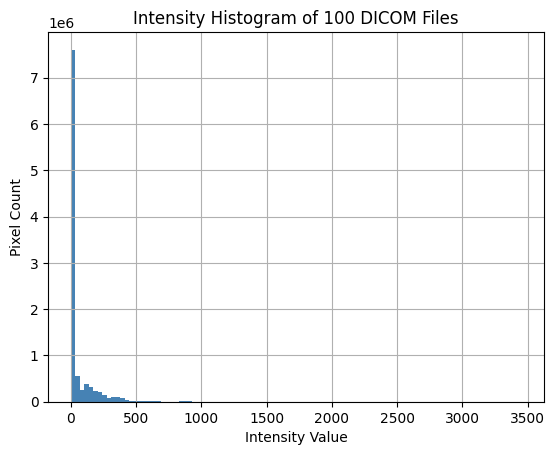

In [121]:
all_pixels = []

for file in dicom_files:
    ds = pydicom.dcmread(file)
    all_pixels.append(ds.pixel_array.flatten())

all_pixels = np.concatenate(all_pixels)
plt.hist(all_pixels, bins=100, color='steelblue')
plt.title("Intensity Histogram of 100 DICOM Files")
plt.xlabel("Intensity Value")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.show()

In [115]:
import random

""" Read the DICOM file """

dcm_file = pydicom.dcmread(dicom_files[random.randint(0, len(dicom_files)-1)])
print('DICOM file information:')
print(f'Patient ID: {dcm_file.PatientID}')
print(f'Patient Name: {dcm_file.PatientName}')

DICOM file information:
Patient ID: Anonymous
Patient Name: Anonymous


In [116]:
""" Pixel Data Extraction """
pixel_array = dcm_file.pixel_array
print(f'Pixel Array Shape: {pixel_array.shape}')
print(f'Pixel Array Type: {pixel_array.dtype}')


Pixel Array Shape: (320, 320)
Pixel Array Type: uint16


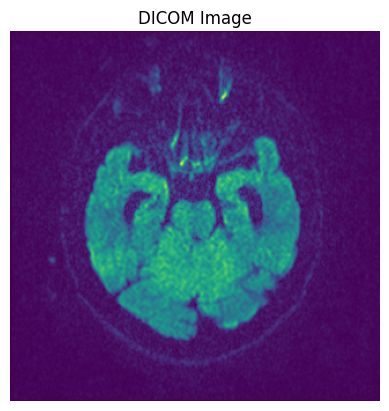

In [117]:
""" Display the Image """
plt.imshow(pixel_array)
plt.title('DICOM Image')
plt.axis('off')
plt.show()